In [7]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import ipywidgets as wg

In [8]:
def Gaussian(x, m, s):
    """Calculates a Gaussian for an array of positions.

    Args:
        x (array): positions.
        m (float): mean.
        s (float): standard deviation.

    Returns:
        (array): Gaussian values at x."""

    G = 1 / np.sqrt(s * np.sqrt(2 * np.pi)) * np.exp(-((x - m) ** 2) / (4 * s**2))

    return G


def Exponential(x, gamma):
    """Calculates an Exponential enveloppe for an array of positions.

    Args:
        x (array): positions.
        gamma (float): exponential parameter.

    Returns:
        (array): Exponential values at x."""

    E = (gamma) ** (1 / 2) * np.exp(-gamma * x / 2) * np.heaviside(x, 1)

    return E


def Overlap(u, v, x):
    """Calculates the overlap integral between 2 wave functions.

    Args:
        u (array): wave function 1.
        v (array): wave function 2..
        x (array): positions.

    Returns:
        (float): Overlap integral value."""

    OverLap = sc.integrate.simps(np.conj(u) * v, x)

    return OverLap

In [9]:
def qr_mgs_decompose(matrix: np.array) -> (np.array, np.array):
    """
    For n x m matrix return Q1 and R1 components of QR decomposition using
    the modified Gram-Schmidt process, where R1 is n x n upper triangular
    and Q1 is m x n and have orthogonal columns.
    """
    n = matrix.shape[1]
    q1 = np.array(matrix, dtype='float64')
    r1 = np.zeros((n, n))
    for k in range(n):
        a_k = q1[..., k]
        r1[k,k] = np.linalg.norm(a_k)
        a_k /= r1[k, k]
        for i in range(k+1, n):
            a_i = q1[..., i]
            r1[k,i] = np.transpose(a_k) @ a_i
            a_i -= r1[k, i] * a_k
    return q1, r1

def characterize_basis(Q:np.ndarray)-> np.ndarray:
    H = Q.T@Q
    err_norm = np.max(np.abs(np.diag(H)-1))
    
    for i in range(H.shape[0]):
        H[i,i] = 0
    
    err_orth = np.max(H)
    
    print(f'Worse error from ||v_i|| = 1  condition is {err_norm}')
    print(f'Worse error from othoginality is {err_orth}')
    return err_norm + err_orth

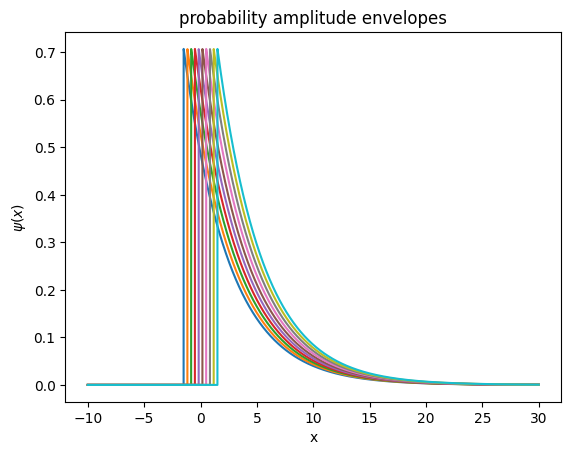

0
Worse error from ||v_i|| = 1  condition is 1.2212453270876722e-15
Worse error from othoginality is 7.916916062766323e-16
1
Worse error from ||v_i|| = 1  condition is 6.661338147750939e-16
Worse error from othoginality is 1.158391571491467e-16
2
Worse error from ||v_i|| = 1  condition is 6.661338147750939e-16
Worse error from othoginality is 1.158391571491467e-16
3
Worse error from ||v_i|| = 1  condition is 6.661338147750939e-16
Worse error from othoginality is 1.158391571491467e-16
4
Worse error from ||v_i|| = 1  condition is 6.661338147750939e-16
Worse error from othoginality is 1.158391571491467e-16
5
Worse error from ||v_i|| = 1  condition is 6.661338147750939e-16
Worse error from othoginality is 1.158391571491467e-16
6
Worse error from ||v_i|| = 1  condition is 6.661338147750939e-16
Worse error from othoginality is 1.158391571491467e-16
7
Worse error from ||v_i|| = 1  condition is 6.661338147750939e-16
Worse error from othoginality is 1.158391571491467e-16
8
Worse error from ||v_

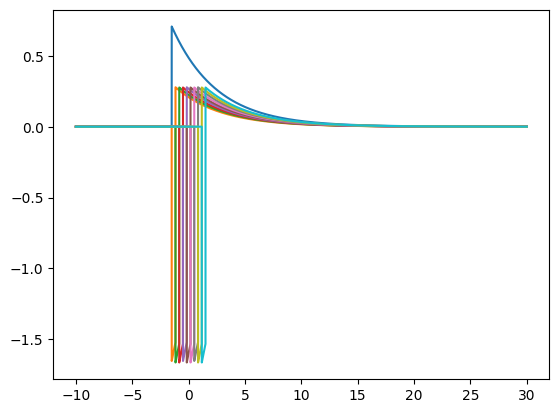

In [13]:
env_type = 2 # 1=Gaussian, 2=exponential
N = 10000  # number of x points to plot the wave functions
N_shift = 10 # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

if env_type == 1:
    sigma_wave = 0.5  # standard deviation of wave function
    x = np.linspace(-30 * sigma_wave, 30 * sigma_wave, N)  # position values
    param_shift = (
        sigma_wave / 10
    )  # standard deviation of shift values (we assume that the shift is normally distributed)
    x_shift = np.linspace(-2*sigma_wave,2*sigma_wave,N_shift) # shift values

    for i in range(N_shift):
        waves[i] = Gaussian(x, x_shift[i], sigma_wave)
if env_type == 2:
    gamma_wave = 0.5
    param = gamma_wave
    x = np.linspace(-5 / gamma_wave, 15 / gamma_wave, N)  # position values
    param_shift = 5 / (gamma_wave) / 10
    x_shift = np.linspace(-3*gamma_wave,3*gamma_wave,N_shift) # shift values

    for i in range(N_shift):
        waves[i] = Exponential(x - x_shift[i], gamma_wave)
# plotting wave functions
plt.figure()
plt.plot(x, waves.T)
plt.xlabel("x")
plt.ylabel(r"$\psi (x)$")
plt.title("probability amplitude envelopes")
plt.show()

for i in range(150):
    # here 10**-14 is a stand in for error limit
    print(i)
    if i==0:
        [new_base,test] = qr_mgs_decompose(waves.T)
    else :
        [new_base,test] = qr_mgs_decompose(new_base)
    if characterize_basis(new_base) < 2*10**-20:
        break 
new_base = new_base.T
for i in range(len(new_base)):
    new_base[i] = new_base[i] / np.sqrt(Overlap(new_base[i], new_base[i], x))

coeffs=np.zeros((N_shift,N_shift))
for i in range(N_shift):
    for j in range(i+1):
        coeffs[i,j]=sc.integrate.simps(waves[i] * new_base[j], x)


waves_new=np.zeros((N_shift,N))
for i in range(N_shift):
    for j in range(N_shift):
        waves_new[i]=waves_new[i]+coeffs[i,j]*new_base[j]
plt.plot(x, new_base.T)

### Checking Orthogonality and normalization

In [14]:
Matrice = []
for i in range(N_shift):
    for j in range(i):
        over = sc.integrate.simps(new_base[i] * new_base[j], x)
        Matrice.append(f"overlap between wave function {i} and wave function {j} : {over}")
        print(f"overlap between wave function {i} and wave function {j} : {over}")
        
    over = sc.integrate.simps(new_base[i] * new_base[i], x)
    Matrice.append(f"overlap between wave function {i} and wave function {i} : {over}")
    print(f"overlap between wave function {i} and wave function {i} : {over}")

overlap between wave function 0 and wave function 0 : 1.0000000000000002
overlap between wave function 1 and wave function 0 : -6.175740436788009e-11
overlap between wave function 1 and wave function 1 : 1.0000000000000002
overlap between wave function 2 and wave function 0 : -6.673274884377455e-11
overlap between wave function 2 and wave function 1 : -2.854385633734629e-11
overlap between wave function 2 and wave function 2 : 1.0
overlap between wave function 3 and wave function 0 : -7.250968524956499e-11
overlap between wave function 3 and wave function 1 : -3.1014877480094945e-11
overlap between wave function 3 and wave function 2 : -3.3514328781275126e-11
overlap between wave function 3 and wave function 3 : 1.0
overlap between wave function 4 and wave function 0 : -7.929876920219977e-11
overlap between wave function 4 and wave function 1 : -3.3918793007372724e-11
overlap between wave function 4 and wave function 2 : -3.665226677673913e-11
overlap between wave function 4 and wave f

### Interactive presentation